In [1]:
## Libraries

suppressMessages(install.packages("readxl"))
suppressMessages(install.packages("ggplot2"))
suppressMessages(install.packages("ggpubr"))

library("readxl", warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(repr, warn.conflicts = FALSE)
library(ggpubr, warn.conflicts = FALSE)

package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kamil\AppData\Local\Temp\RtmpMj4jgT\downloaded_packages
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kamil\AppData\Local\Temp\RtmpMj4jgT\downloaded_packages
package 'ggpubr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kamil\AppData\Local\Temp\RtmpMj4jgT\downloaded_packages


In [2]:
data <- read_excel("data.xlsx")

# Wstępne przetwarzanie danych

- Dopisanie identyfikatorów pacjenta dla wierszy z NA
- Zamiana etykiet kolumn z greckimi literami
- Zamiana dat na numerable
- Usunięcie niepotrzebnych wskaźników (2019-nCoV nucleic acid detection). W przypadku drugiego parametru nie jestem pewny jak interpretować puste wartości. Wartości wypełnione to tylko -1.

In [3]:
previous_id = 1;
loop_iterator = 1;

data <- data %>% rename(`Interleukin 1B` = `Interleukin 1ß`)
data <- data %>% rename(`Tumor necrosis factora` = `Tumor necrosis factorα`)
data <- data %>% rename(`y-glutamyl transpeptidase` = `γ-glutamyl transpeptidase`)

data <- data %>% 
        mutate(nRE_DATE = as.numeric(RE_DATE)) %>%
        mutate(`nAdmission time` = as.numeric(`Admission time`)) %>%
        mutate(`nDischarge time` = as.numeric(`Discharge time`))

data <- select(
            data, 
           -c(
               "Admission time",
               "Discharge time",
               "2019-nCoV nucleic acid detection"
           )
          )

for (record in data$PATIENT_ID) {
    
    if (is.na(record)) {
        data$PATIENT_ID[loop_iterator] = previous_id;
    } else {
        previous_id = record;
    }

    loop_iterator <- loop_iterator + 1;
}

summary(data)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

   PATIENT_ID       RE_DATE                         age            gender     
 Min.   :  1.0   Min.   :2020-01-10 19:45:00   Min.   :18.00   Min.   :1.000  
 1st Qu.: 92.0   1st Qu.:2020-02-04 13:44:00   1st Qu.:47.00   1st Qu.:1.000  
 Median :185.0   Median :2020-02-09 12:42:30   Median :62.00   Median :1.000  
 Mean   :184.8   Mean   :2020-02-08 07:00:02   Mean   :59.44   Mean   :1.391  
 3rd Qu.:270.0   3rd Qu.:2020-02-13 10:34:00   3rd Qu.:71.00   3rd Qu.:2.000  
 Max.   :375.0   Max.   :2020-02-18 17:49:00   Max.   :95.00   Max.   :2.000  
                 NA's   :14                                                   
    outcome       Hypersensitive cardiac troponinI   hemoglobin   
 Min.   :0.0000   Min.   :    1.9                  Min.   :  6.4  
 1st Qu.:0.0000   1st Qu.:    4.4                  1st Qu.:113.0  
 Median :0.0000   Median :   20.6                  Median :125.0  
 Mean   :0.4747   Mean   : 1223.2                  Mean   :123.1  
 3rd Qu.:1.0000   3rd Qu.:  223.8

# Graficzna analiza zależności parametrów od wyniku

W tym kroku, w celu zapoznania się lepiej z danymi, wygenerowałem dla każdego atrybutu wykres zależności outcome od tego atrybutu. Poniżej kilka, moim zdaniem, najciekawszych z nich wraz z komentarzem. 

#### Generowanie wszystkich wykresów
Blok został zakomentowany, ponieważ w sekcji poniżej pokazane są najciekawsze z wyników.

In [4]:
options(repr.plot.width=16, repr.plot.height=10)

show <- function() {
    for (column_name in colnames(data)) {

        kv <- data %>%
                select(!!as.name(column_name), outcome) %>%
                filter(!is.na(!!as.name(column_name))) %>%
                count(!!as.name(column_name), outcome)

        print(ggplot(kv, aes(x=!!as.name(column_name), y=outcome, size = n))
              + geom_point(alpha=0.7)
              + ggtitle(paste("Zależnośc wyniku badania od atrybutu: ", column_name))
              + theme(text = element_text(size=20))
             )
    }
}

# show()

#### Najciekawsze (według mnie) wykresy

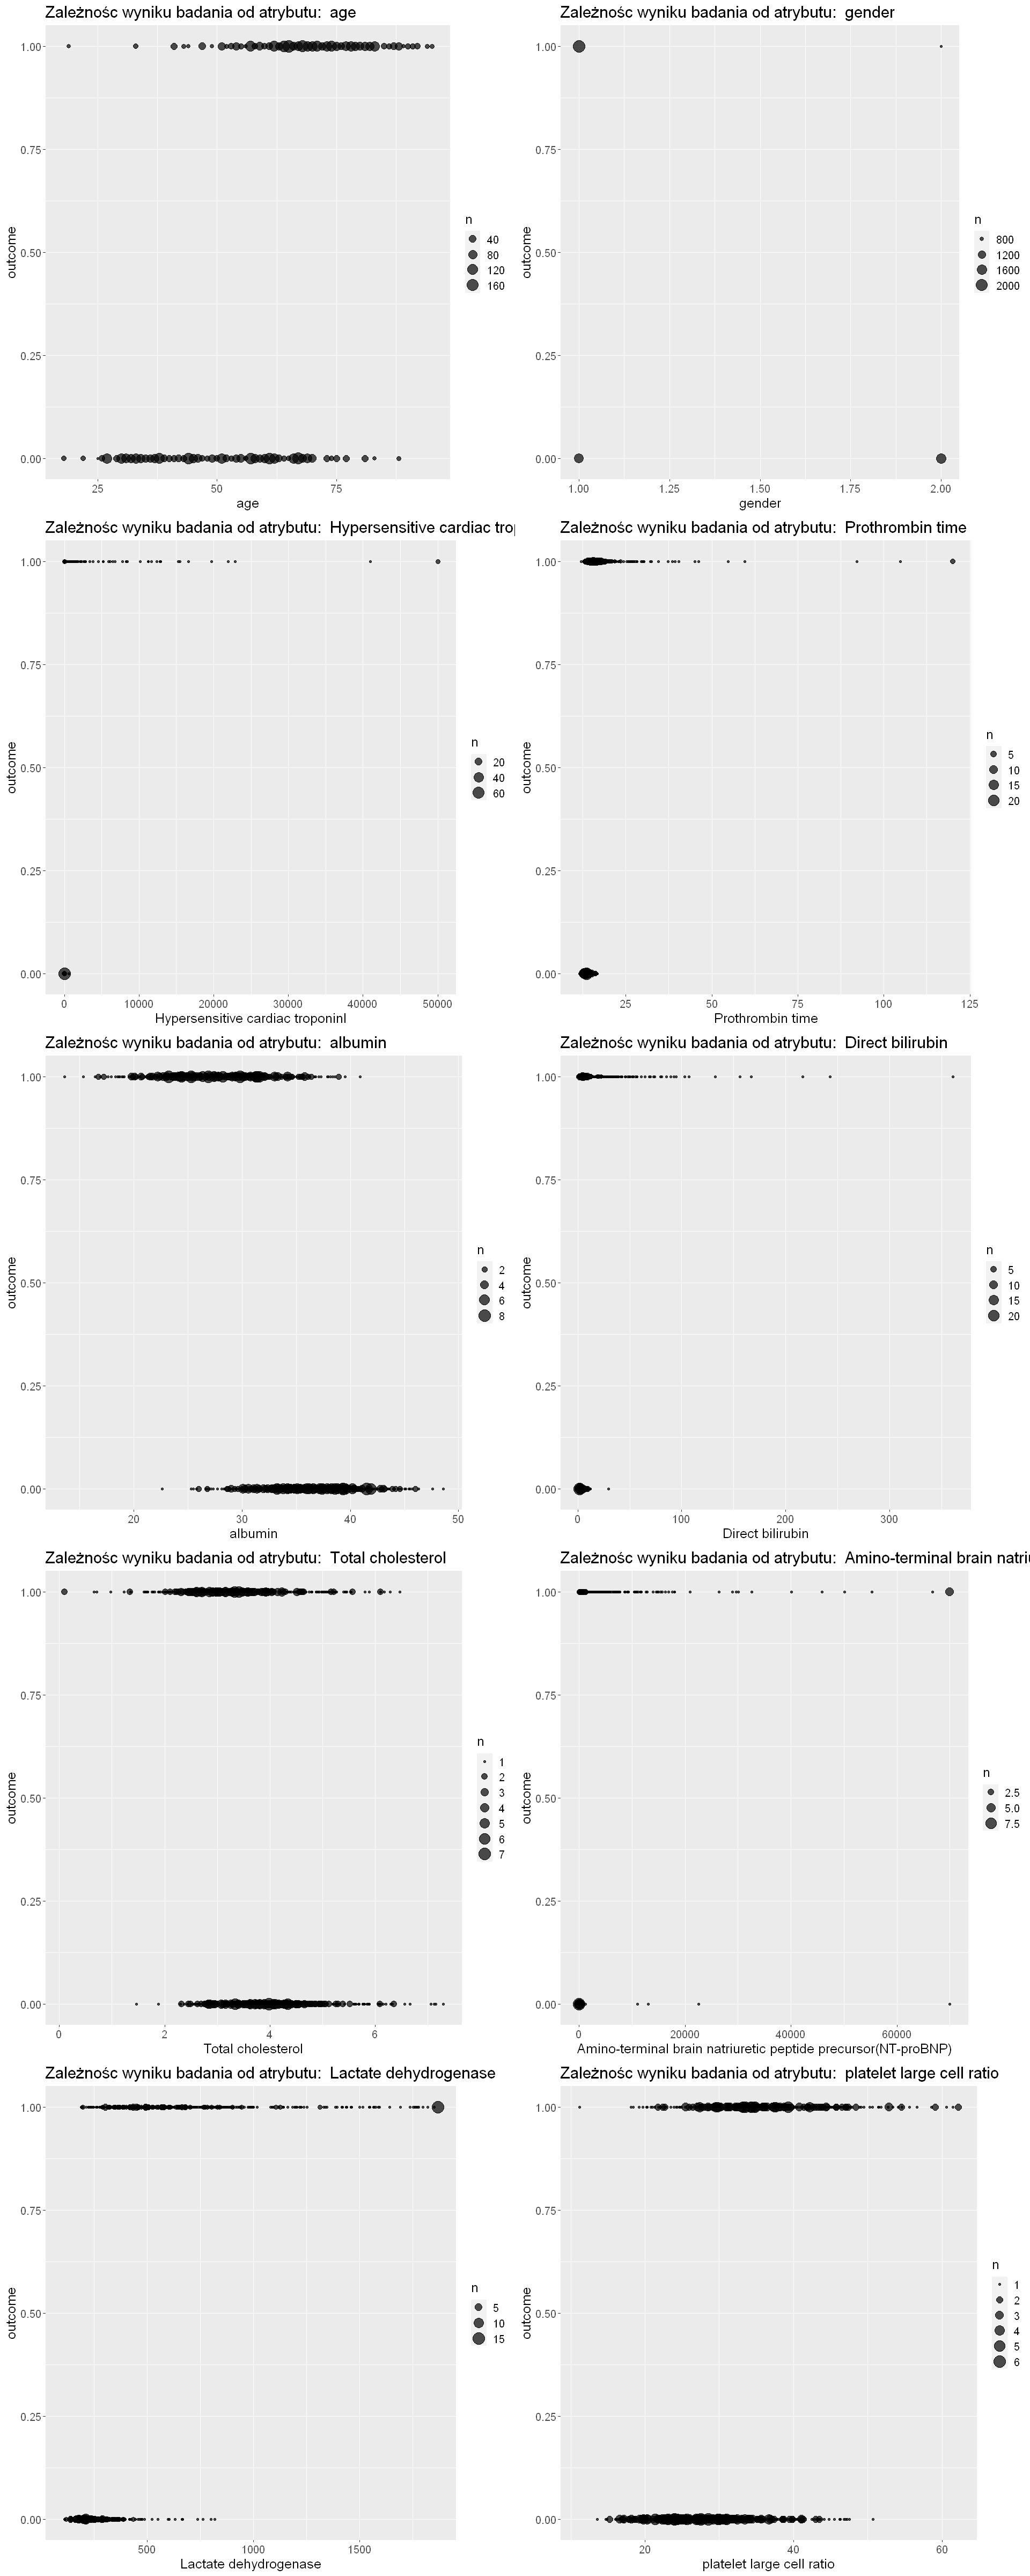

In [5]:
options(repr.plot.width=16, repr.plot.height=40)
plots = list()
interesting_cols = c(
    "age",
    "gender",
    "Hypersensitive cardiac troponinI",
    "Prothrombin time",
    "albumin",
    "Direct bilirubin",
    "Total cholesterol",
    "Amino-terminal brain natriuretic peptide precursor(NT-proBNP)",
    "Lactate dehydrogenase",
    "platelet large cell ratio"
)
i = 1

for (column_name in interesting_cols) {
    kv <- data %>%
                select(!!as.name(column_name), outcome) %>%
                filter(!is.na(!!as.name(column_name))) %>%
                count(!!as.name(column_name), outcome)

    plots[[i]] <- (ggplot(kv, aes(x=!!as.name(column_name), y=outcome, size = n))
          + geom_point(alpha=0.7)
          + ggtitle(paste("Zależnośc wyniku badania od atrybutu: ", column_name))
          + theme(text = element_text(size=15))
         )
    
    i = i + 1
}

ggarrange(
    plots[[1]],
    plots[[2]],
    plots[[3]],
    plots[[4]],
    plots[[5]],
    plots[[6]],
    plots[[7]],
    plots[[8]],
    plots[[9]],
    plots[[10]],
    ncol = 2, nrow = 5)

# Korelacja atrybutów
Lista kilku atrybutów, których korelacja w stosunku do atrubutu "outcome" jest największa

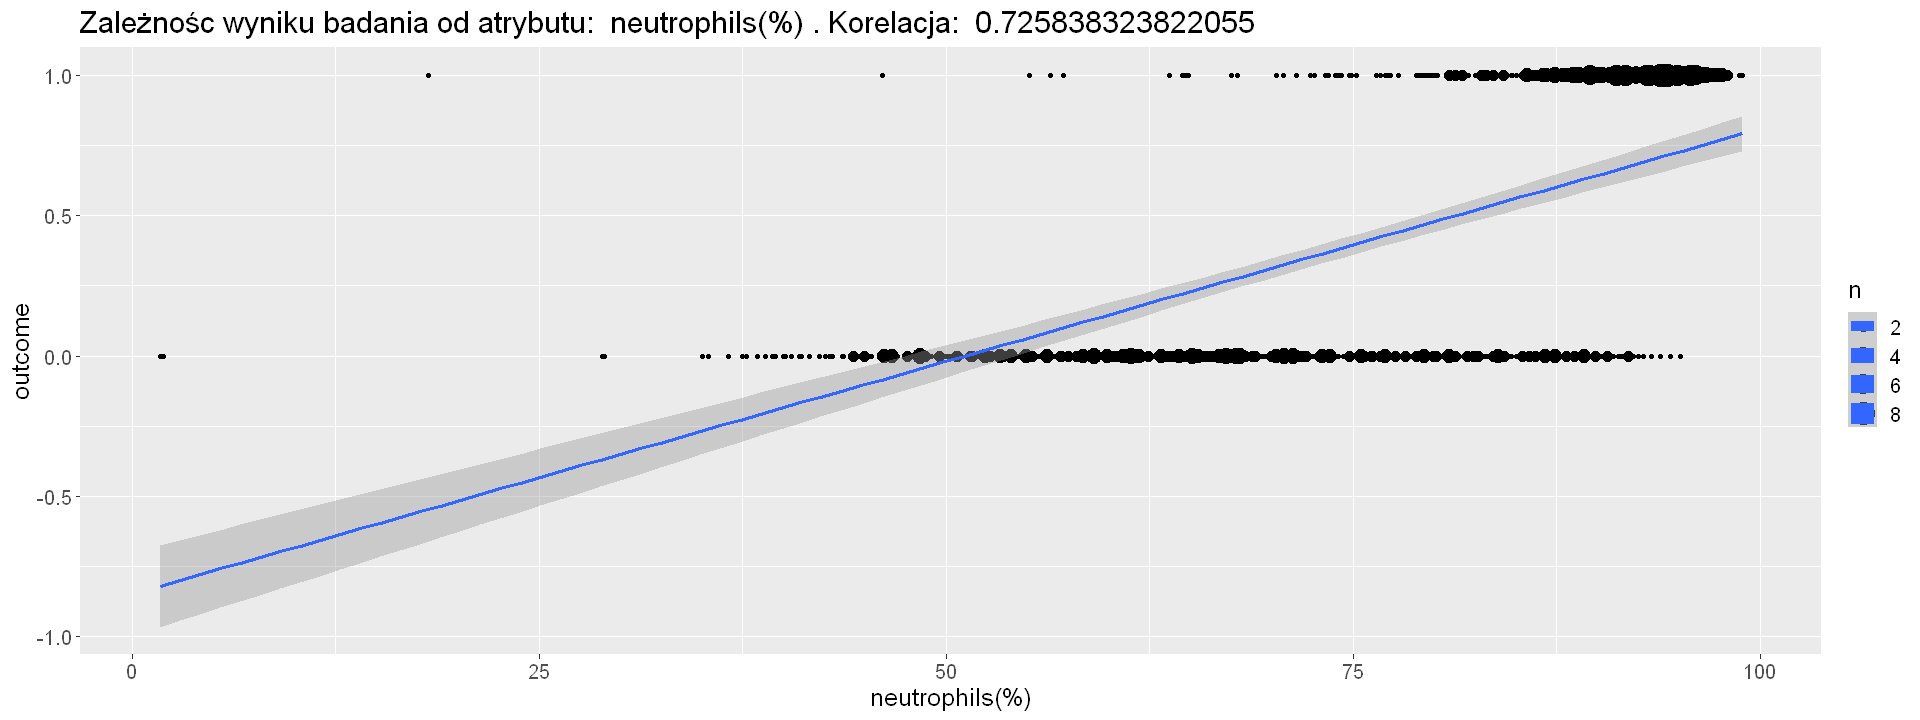

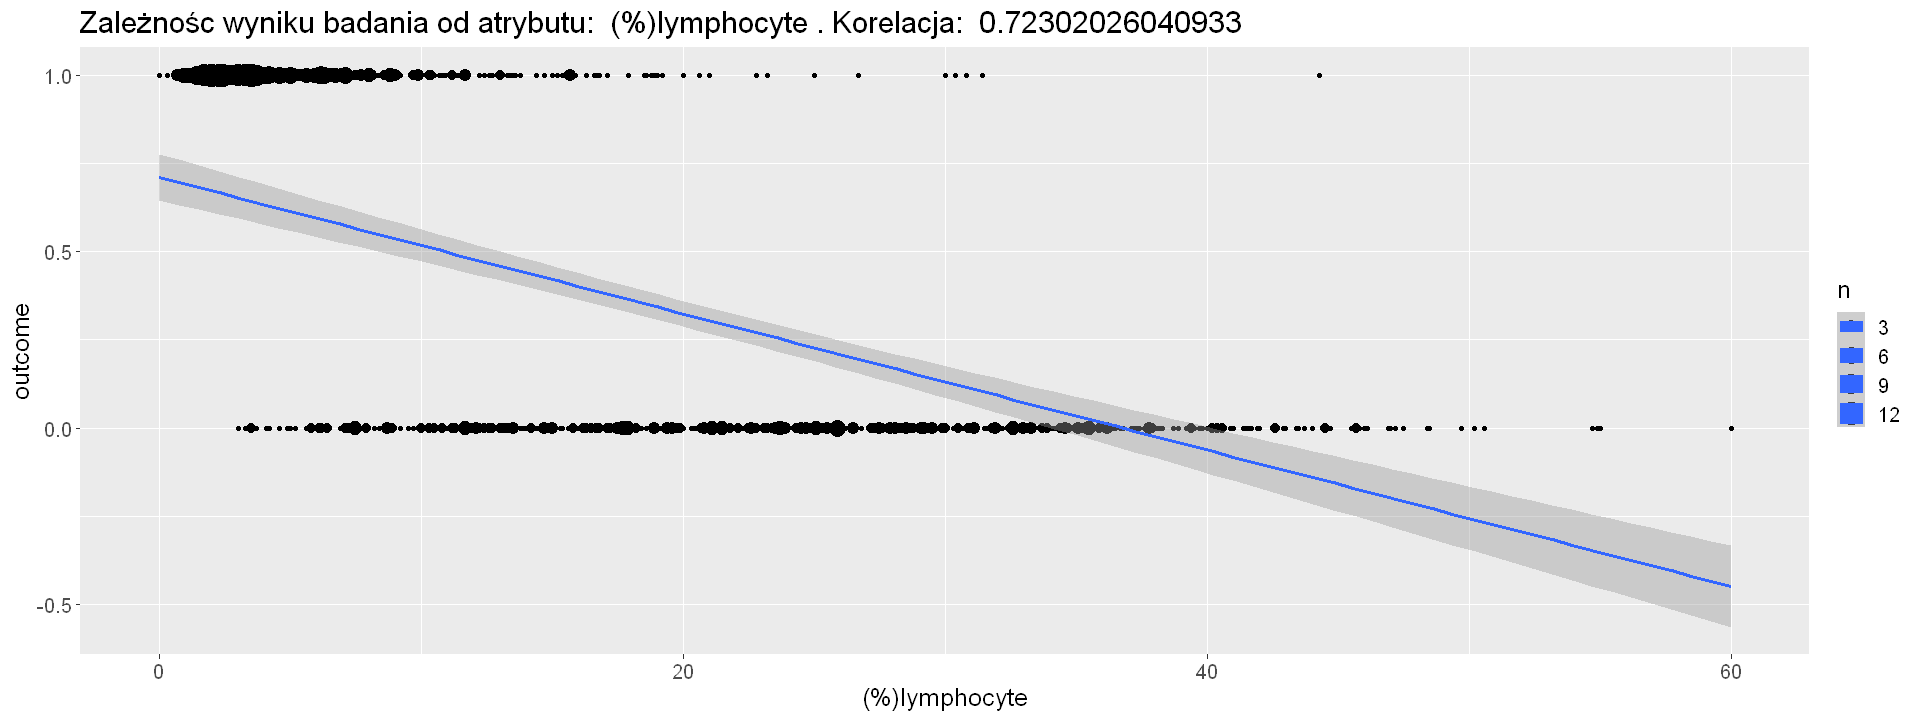

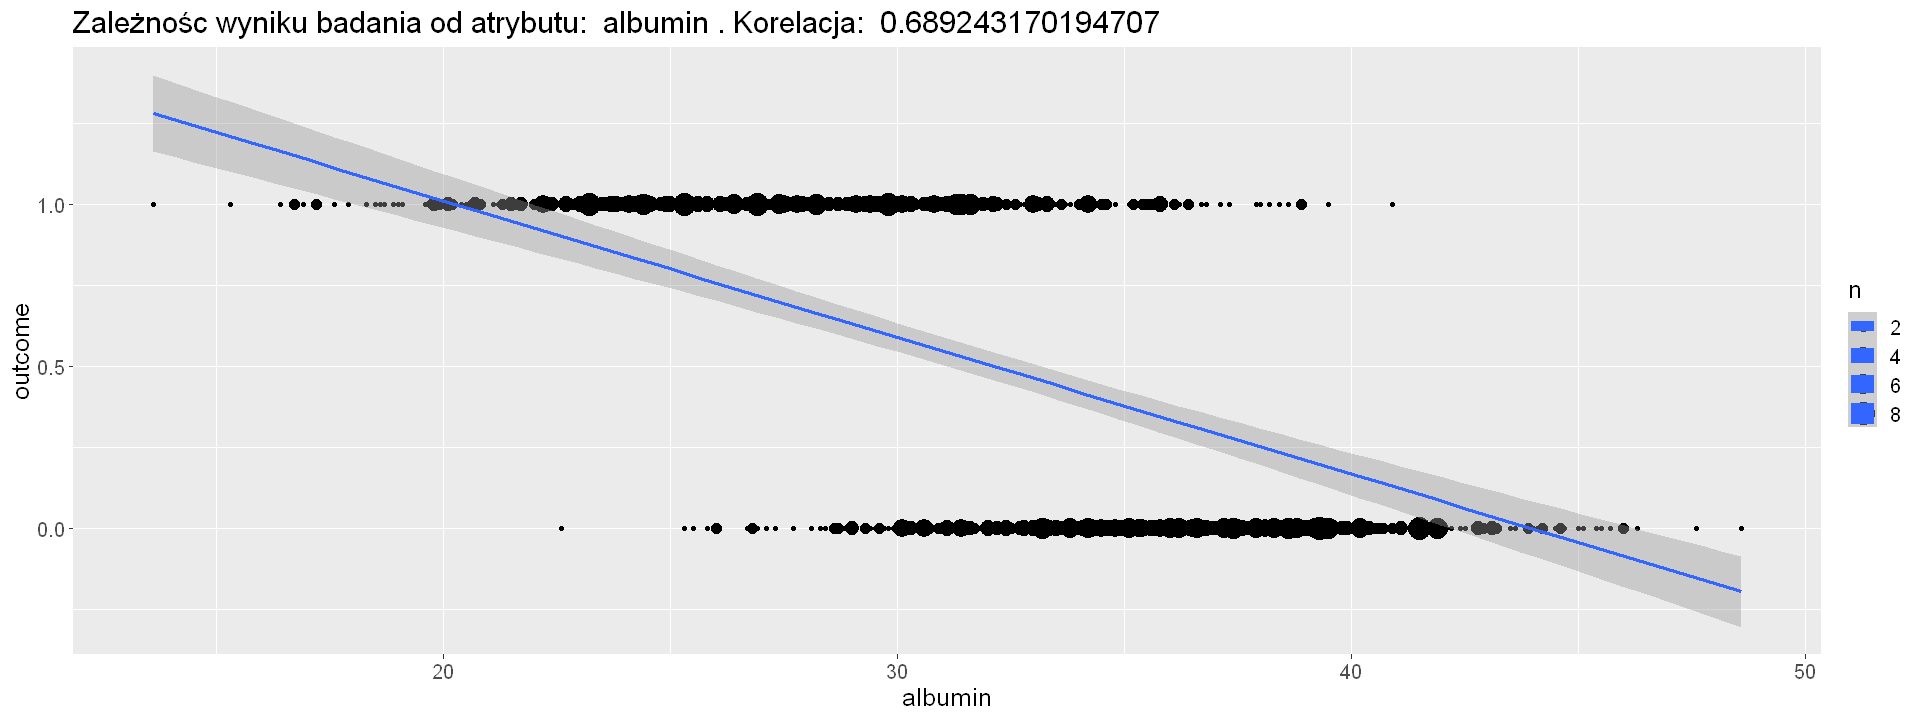

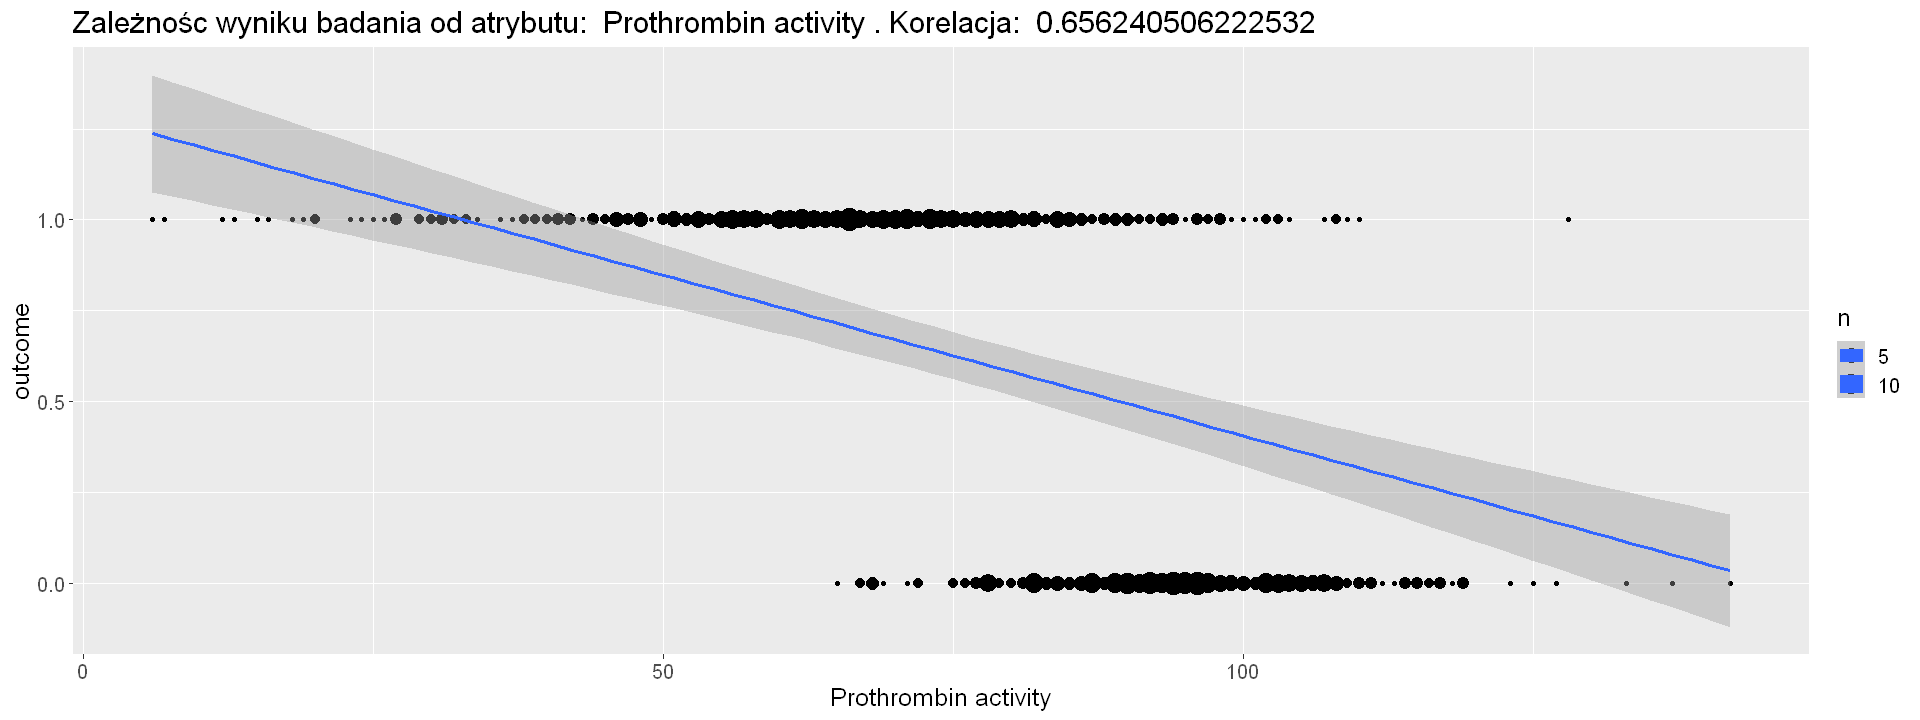

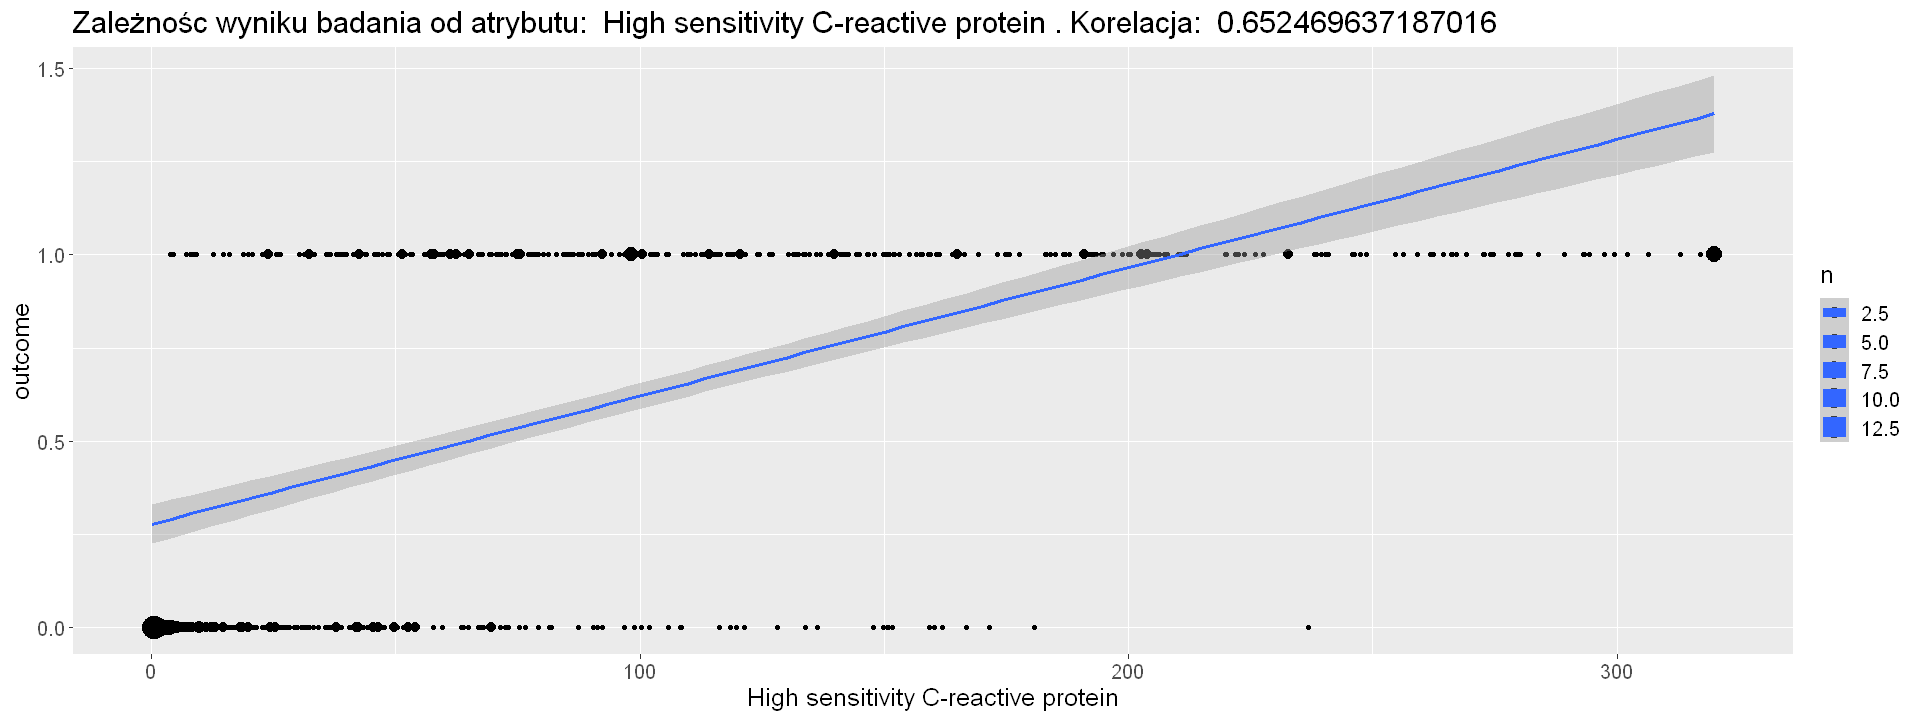

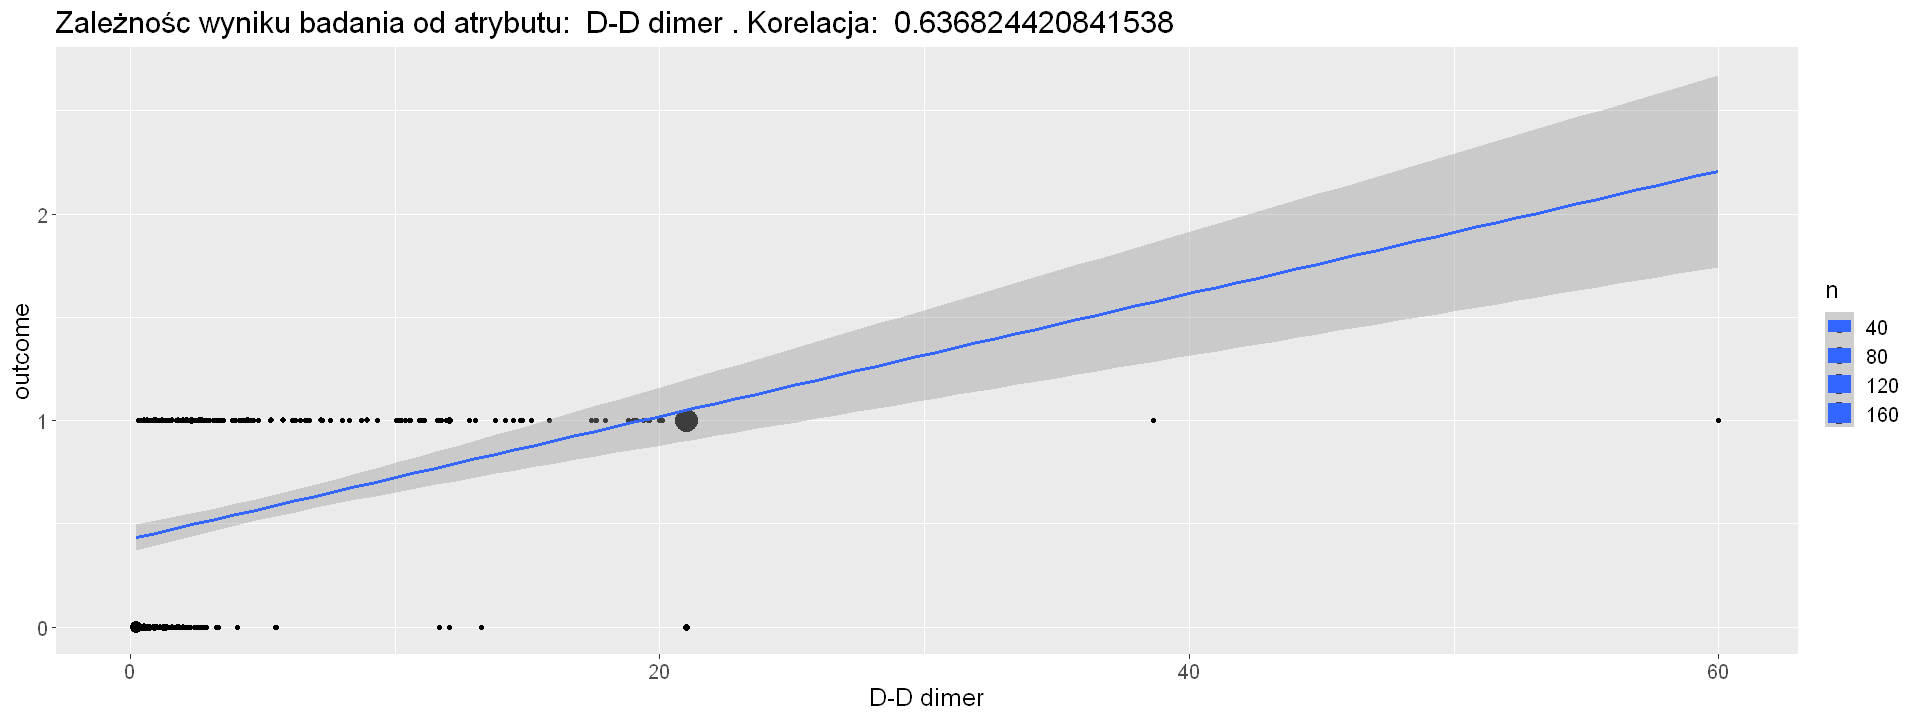

In [164]:
korelacje = {}

for (column_name in colnames(select(data, -c("outcome", "PATIENT_ID", "RE_DATE")))) {
    kv <- data %>%
            select(!!as.name(column_name), outcome) %>%
            filter(!is.na(!!as.name(column_name)))
    
    korelacje[column_name] <- abs(cor(kv$outcome, kv %>% select(all_of(column_name))))
}

ordered <- korelacje[order(unlist(korelacje))]

options(repr.plot.width=16, repr.plot.height=6)
names <- names(rev(ordered))[1:6]

for (column_name in names) {
    kv <- data %>%
                select(!!as.name(column_name), outcome) %>%
                filter(!is.na(!!as.name(column_name))) %>%
                count(!!as.name(column_name), outcome)

    plot <- ggplot(kv, aes(x=!!as.name(column_name), y=outcome, size = n)) +
            geom_point() +
            geom_smooth(method="lm") +
            ggtitle(paste("Zależnośc wyniku badania od atrybutu: ", column_name, ". Korelacja: ", ordered[column_name])) + 
            theme(text = element_text(size=15))
    
    suppressMessages(print(plot))
}

# Zmiana parametrów w czasie
Wizualizacja zmiany współczynników krwi u pacjentów w czasie przebywania choroby ze skutkiem śmiertelnym. 

In [146]:
dead <- data %>%
            filter(outcome == 1) %>%
            select(c(1, 2, 5:(length(data) - 3) ))
            

patients_data = NA
initialized = FALSE

for (patient_id in dead$PATIENT_ID) {
    patient_data <- dead %>%
                    filter(PATIENT_ID==patient_id) %>%
                    mutate(day=format(RE_DATE, format='%m/%d/%Y')) %>%
                    group_by(day, PATIENT_ID) %>%
                    summarise_each(funs(mean(., na.rm = TRUE))) %>%
                    arrange(desc(RE_DATE))
    
    patient_data$day = seq.int(nrow(patient_data))
    
    if (!initialized) {
        patients_data = patient_data
        initialized =TRUE
    } else {
        patients_data = union(patients_data, patient_data)
    }
    
}

max_day <- max(patients_data["day"])
patients_data <- patients_data %>% select(c(1, 2, 5:length(patients_data)))
patients_data <- patients_data %>% mutate(day=(max_day - day + 1))

In [173]:
patients_data <- ungroup(patients_data)

Wyniki analizy przedstawiąją zmianę parametrów krwi przed zgonem. Skrajny prawy słupek oznacza współczynniki krwi u pacjenta w dniu zgonu (dla wielu pomiarów wyciągana jest średnia). Przeciętnie pacjenci trafiali do szpitala kilka dni przed zgonem, dlatego wyniki badań krwi pacjentów kilkanaście dni przed zgonem (lewa stronwa wykresu) są szczątkowe. 

Poniższy skrypt przedstawia sposób wygenerowania wszystkich wykresów. Podobnie jak w przypadku poprzedniej analizy, spośród wszystkich wybrałem kilka interesujących i przedstawię tylko te.

In [161]:
options(repr.plot.width=16, repr.plot.height=10)
hide_cols = c("day", "PATIENT_ID")

show <- function(to_show) {
    for (column_name in to_show) {
        
        if (column_name %in% hide_cols) {
            next
        }

        kv <- patients_data %>%
                select(!!as.name(column_name), day) %>%
                filter(!is.na(!!as.name(column_name)))

        print(
                ggplot(kv, aes(x=day, y=!!as.name(column_name)))
              + geom_point()
              + ggtitle(paste("Zależnośc wyniku badania od atrybutu: ", column_name))
              + theme(text = element_text(size=20))
             )
    }
}

# show(colnames(patients_data))

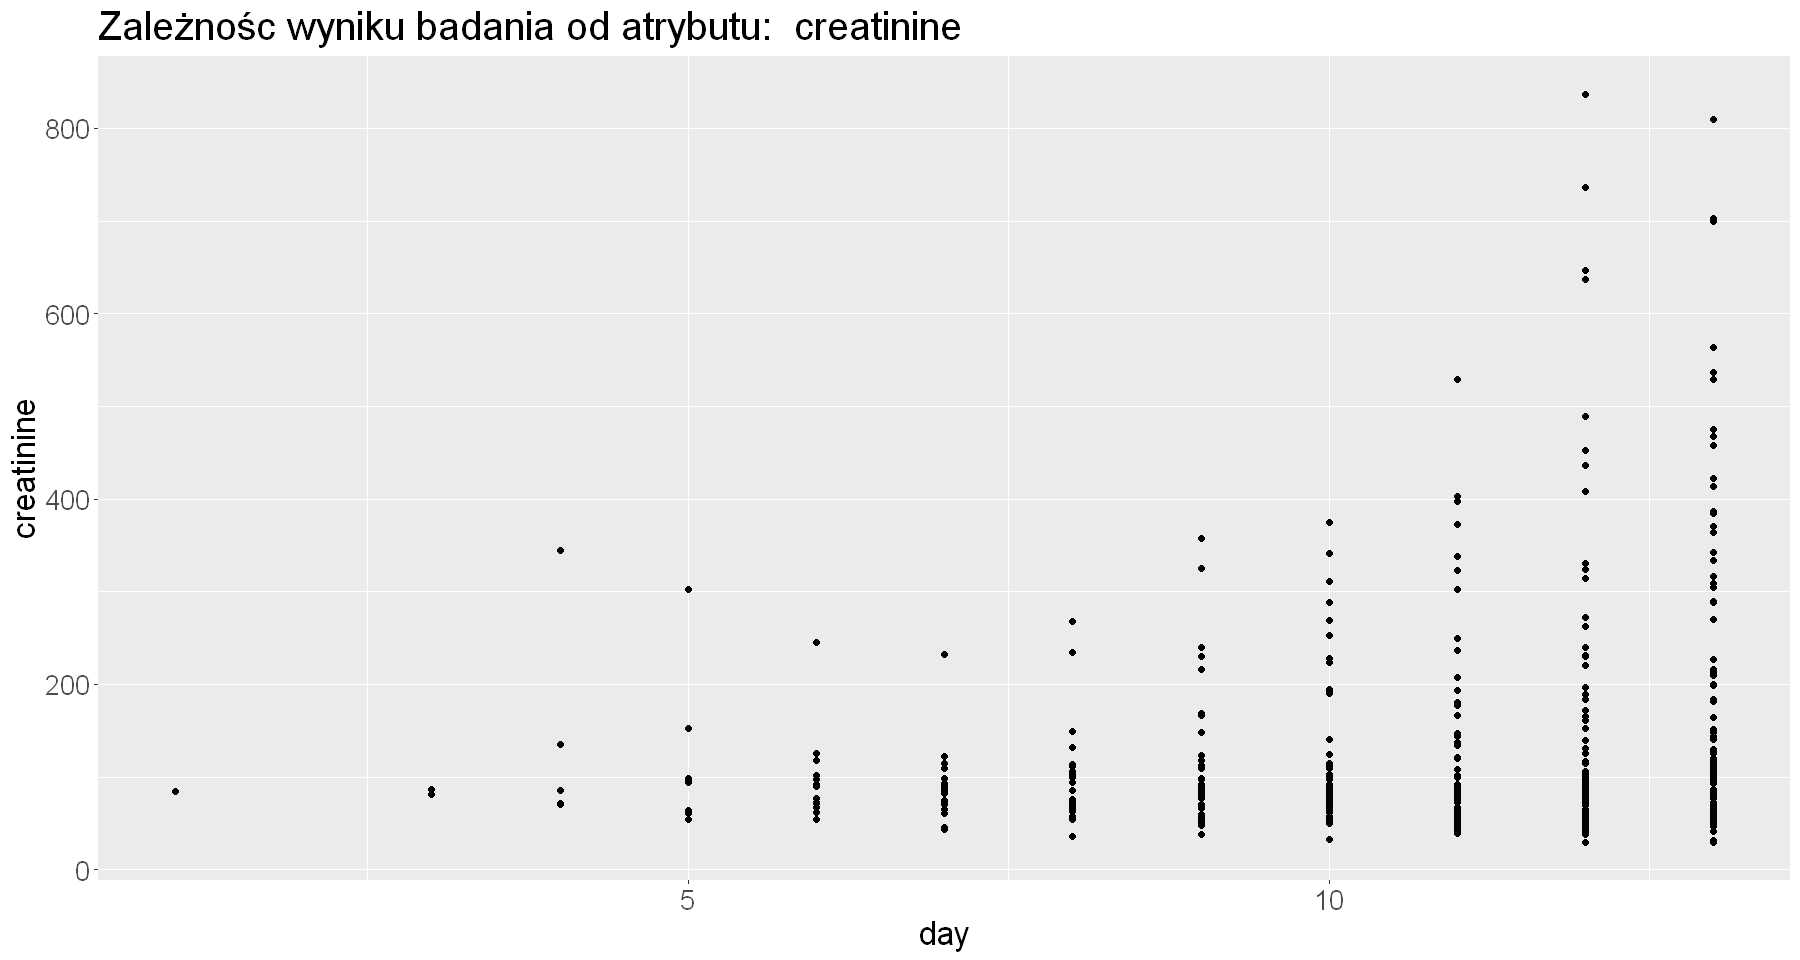

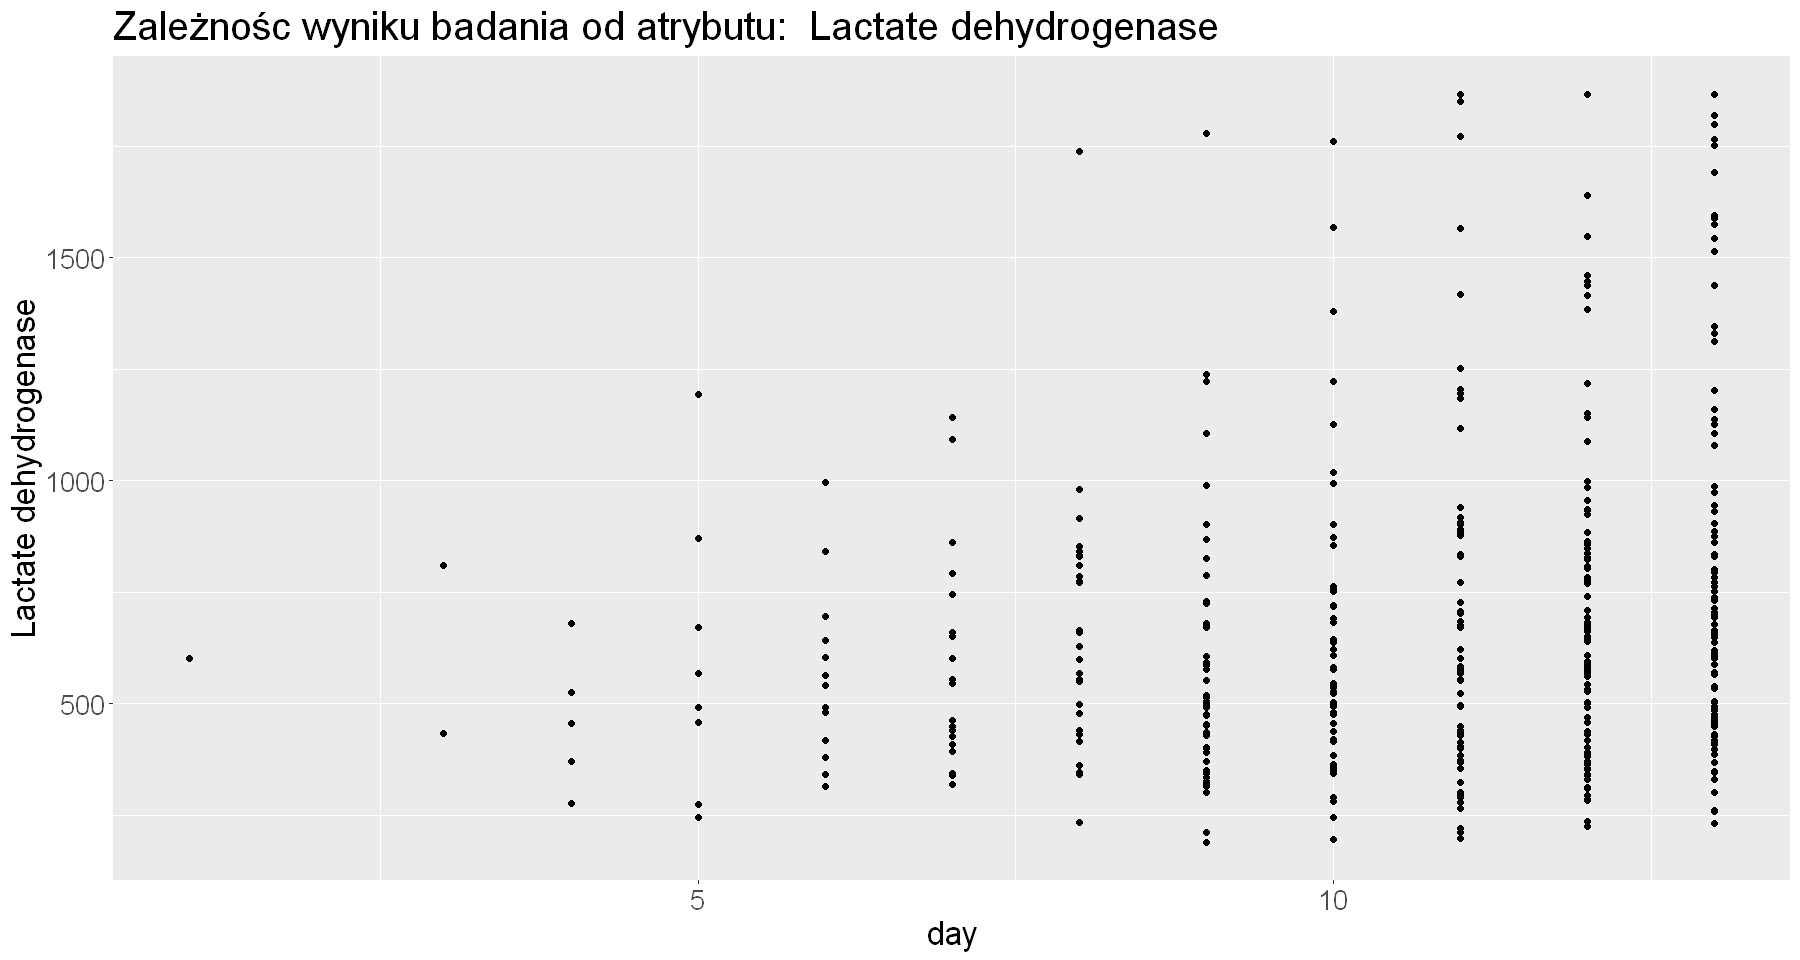

In [163]:
options(repr.plot.width=15, repr.plot.height=8)

show(c("creatinine", "Lactate dehydrogenase"))

Podobnej selekcji najciekawszysch wyników dokonałem także dla uwzględniając korelacje atrybutów. Zgodnie z tym współczynnikiem najbardziej interesujące atrybuty to:

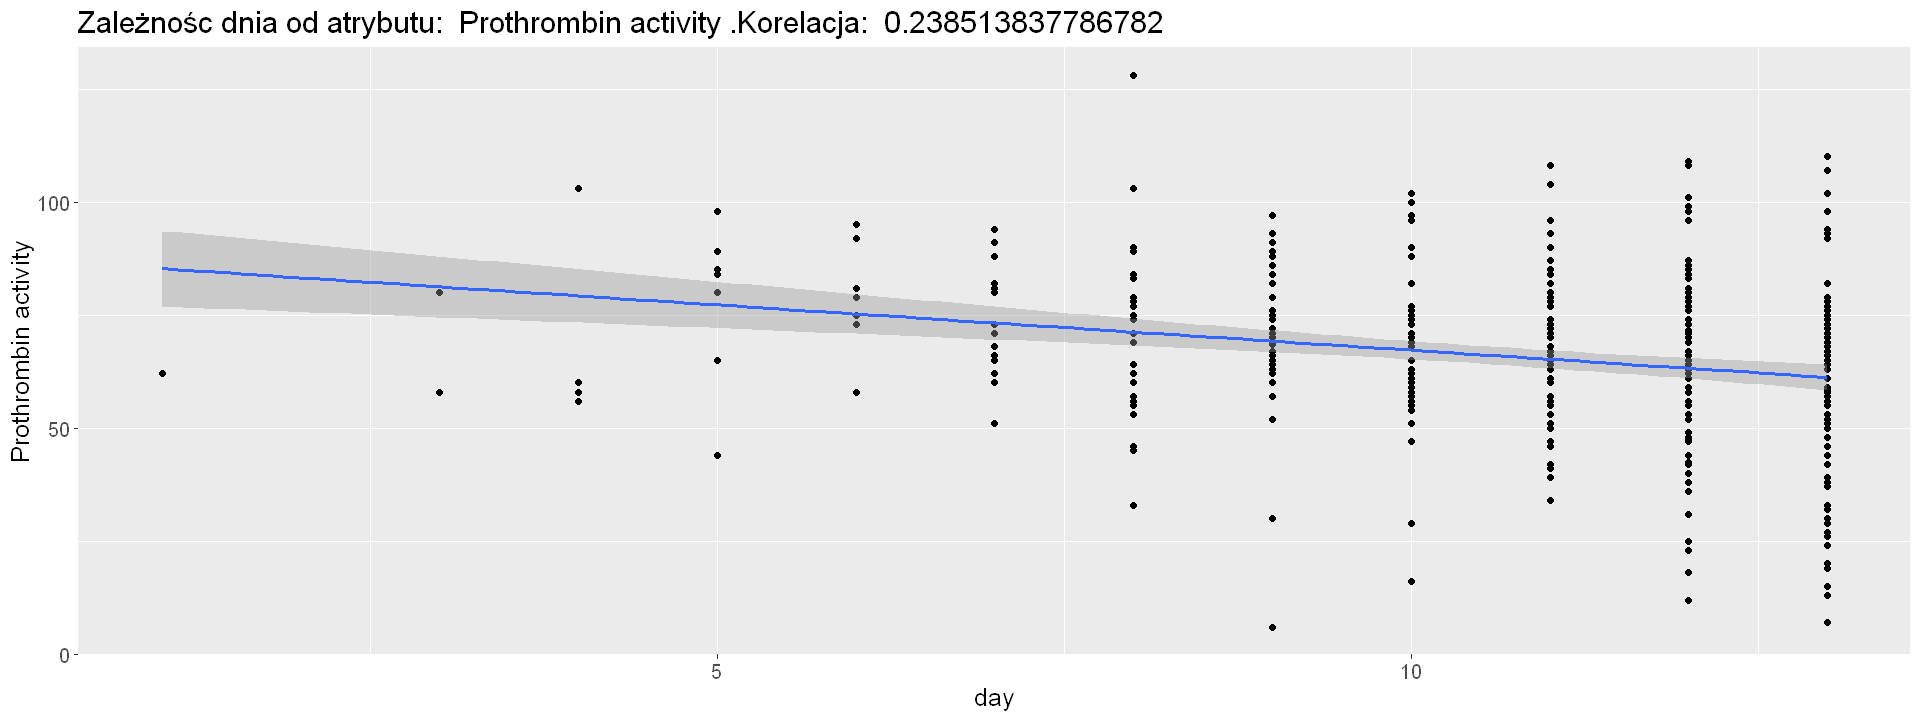

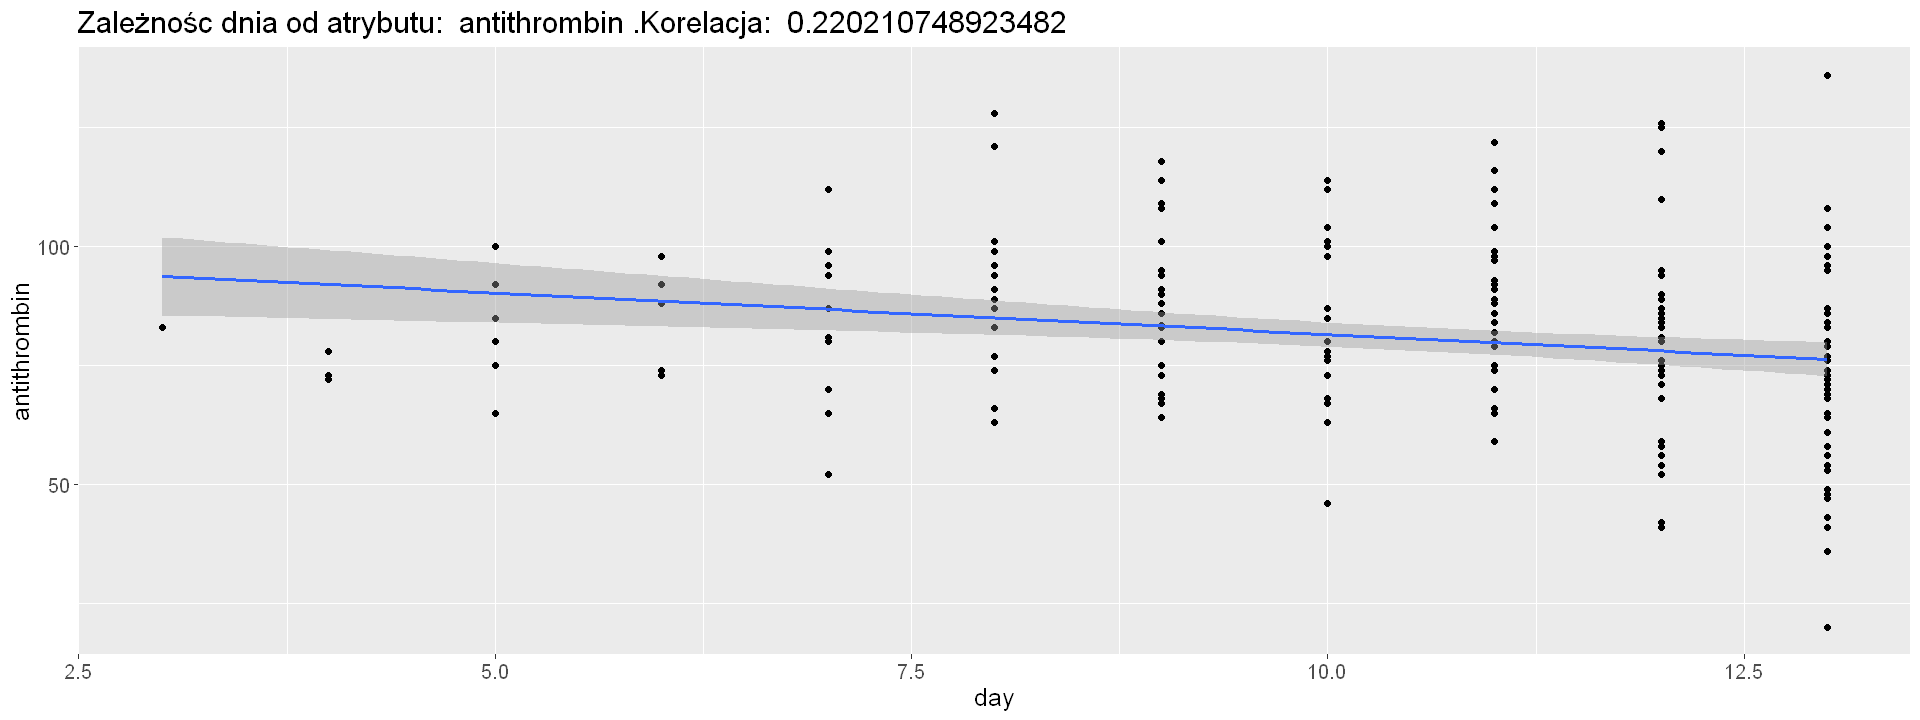

In [178]:
korelacje = {}
hide_cols = c("day", "PATIENT_ID")

for (column_name in colnames(patients_data)) {
    
    if (column_name %in% hide_cols) {
        next
    }
    
    kv <- patients_data %>%
            select(!!as.name(column_name), day) %>%
            filter(!is.na(!!as.name(column_name)))
    
    
    
    korelacje[column_name] <- abs(cor(kv$day, kv %>% select(all_of(column_name))))
}

ordered <- korelacje[order(unlist(korelacje))]

options(repr.plot.width=16, repr.plot.height=6)
names <- names(rev(ordered))[1:2]

for (column_name in names) {
    kv <- patients_data %>%
                select(!!as.name(column_name), day) %>%
                filter(!is.na(!!as.name(column_name)))

    plot <- ggplot(kv, aes(x=day, y=!!as.name(column_name))) +
            geom_point() +
            geom_smooth(method="lm") +
            ggtitle(paste("Zależnośc dnia od atrybutu: ", column_name, ".Korelacja: ", ordered[column_name])) + 
            theme(text = element_text(size=15))
    
    suppressMessages(print(plot))
}

# Klasyfikacja

In [92]:
dead <- data %>%
            select(PATIENT_ID, RE_DATE, outcome, hemoglobin) %>%
            filter(outcome == 1) %>%
            filter(!is.na(!!as.name("hemoglobin"))) %>%
            arrange(desc(RE_DATE))

# format(as.POSIXct(v,format='%m/%d/%Y %H:%M:%S'),format='%m/%d/%Y')

patients_data = NA
initialized = FALSE

for (patient_id in dead$PATIENT_ID) {
    
    patient_data <- suppressMessages(dead %>%
                    filter(PATIENT_ID==patient_id) %>%
                    mutate(day=format(RE_DATE, format='%m/%d/%Y')) %>%
                    select(PATIENT_ID, hemoglobin, day) %>%
                    group_by(day, PATIENT_ID) %>%
                    summarise(
                        hemoglobin=mean(hemoglobin)
                    )) %>%
                    select(PATIENT_ID, day, hemoglobin)
    
    patient_data$day = seq.int(nrow(patient_data))

    if (!initialized) {
        patients_data = patient_data
        initialized =TRUE
    } else {
        patients_data = union(patients_data, patient_data)
    }
}

max_day <- max(patients_data["day"])
patients_data %>% mutate(day=(max_day - day + 1))

PATIENT_ID,day,hemoglobin
<dbl>,<dbl>,<dbl>
257,11,129.0
257,10,128.0
257,9,127.0
257,8,110.0
252,11,119.0
252,10,136.0
252,9,131.0
252,8,114.0
252,7,119.0


PATIENT_ID,day,hemoglobin
<dbl>,<dbl>,<dbl>
257,11,129.0
257,10,128.0
257,9,127.0
257,8,110.0
252,11,119.0
252,10,136.0
252,9,131.0
252,8,114.0
252,7,119.0


In [9]:
# outcome_grouped <- data %>%
#         group_by(PATIENT_ID) %>%
#         summarize(outcome=max(outcome)) %>%
#         select(outcome) %>%
#         group_by(outcome) %>%
#         count(outcome) %>%
#         rename(total = n)

# dead <- (outcome_grouped %>% filter(outcome==1))[["total"]]
# alived <- (outcome_grouped %>% filter(outcome==0))[["total"]]

# slices <- c(dead, alived)
# lbls <- c(paste("Zgony:  ", dead), paste("Ozdrowienia: ", alived))
# pie(slices, labels = lbls, main="Śmiertelność wśród pacientów")

In [10]:
# options(repr.plot.width=18, repr.plot.height=10)

# for (column_name in colnames(data)[1:8]) {
    
# #     wynik <- {}
# #     wynik["pozytywny"] <- {}
# #     wynik["negatywny"] <- {}
    
#     kv <- data %>%
#             select(!!as.name(column_name), outcome) %>%
#             count(!!as.name(column_name), outcome)
    
#     print(ggplot(kv, aes(x=!!as.name(column_name), y=outcome, size = n)) + geom_point(alpha=0.7))
#     break;
# }

In [11]:
# for (column_name in colnames(data)[4:8]) {
# #     print(data %>% pull(column_name))
# #     print(data$outcome)
    
#     y = c(data$outcome)
#     x = c(data %>% pull(column_name))
#     names(x) = y
    
#     ggplot(displ, hwy, data=data, mapping=aes(outcome, outcome))
    
# #     plot(
# #         x,
# #         col = "red",
# #         xlab = "Wynik testu",
# #         ylab = column_name,
# #     )
    
#     break;
# }

In [12]:
# cn <- "outcome"
# qplot(displ, hwy, mapping=aes(data %>% pull("outcome"), data %>% pull("outcome")))